In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
data = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)
data

,gameSeconds,period,x_coordinate,y_coordinate,shotDistance,shotAngle,shotType,LastEventType,Last_x_coordinate,Last_y_coordinate,timeFromLastEvent,DistanceLastEvent,Rebound,changeShotAngle,speed,time_since_pp,no_players_home,no_players_away,is_goal
0,15,1,36.0,-23.0,57.775427,23.459024,Wrist Shot,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,5.0,5.0,0
1,20,1,63.0,0.0,26.000000,0.000000,Wrist Shot,Shot,36.0,-23.0,5.0,35.468296,True,23.459024,7.093659,0.0,5.0,5.0,1
2,121,1,79.0,0.0,10.000000,0.000000,Tip-In,Goal,63.0,0.0,101.0,16.000000,False,0.000000,0.158416,0.0,5.0,5.0,0
3,154,1,-69.0,-16.0,25.612497,38.659808,Wrist Shot,Shot,79.0,0.0,33.0,148.862353,True,38.659808,4.510980,0.0,5.0,5.0,0
4,165,1,-63.0,-12.0,28.635642,24.775141,Wrist Shot,Shot,-69.0,-16.0,11.0,7.211103,True,63.434949,0.655555,0.0,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2950,5,-34.0,-24.0,60.008333,23.574706,Wrist Shot,Shot,30.0,-29.0,1040.0,64.195015,True,49.749996,0.061726,0.0,5.0,5.0,0
327338,3005,5,-69.0,32.0,37.735925,57.994617,Slap Shot,Shot,-34.0,-24.0,55.0,66.037868,True,81.569323,1.200689,0.0,5.0,5.0,0
327339,3050,5,82.0,26.0,26.925824,74.931512,Slap Shot,Shot,-69.0,32.0,45.0,151.119158,True,132.926129,3.358204,0.0,5.0,5.0,0
327340,3410,5,-62.0,-29.0,39.623226,47.045408,Snap Shot,Shot,82.0,26.0,360.0,154.146035,True,121.976920,0.428183,0.0,5.0,5.0,0


In [4]:
X = data[['shotDistance', 'shotAngle', 'is_goal' ]]
X

,shotDistance,shotAngle,is_goal
0,57.775427,23.459024,0
1,26.000000,0.000000,1
2,10.000000,0.000000,0
3,25.612497,38.659808,0
4,28.635642,24.775141,0
...,...,...,...
327337,60.008333,23.574706,0
327338,37.735925,57.994617,0
327339,26.925824,74.931512,0
327340,39.623226,47.045408,0


In [5]:
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")
X.shape

There are no NaN values in the DataFrame 'X'.


(327342, 3)

In [6]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]
y

0         0
1         1
2         0
3         0
4         0
         ..
327337    0
327338    0
327339    0
327340    0
327341    1
Name: is_goal, Length: 327342, dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
# Compute metrics
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
metrics = {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}
params = {
    "model": 'XGBoost',
    "description": 'XGBClassifier Baseline Distance+Angle',
}
metrics

{'accuracy': 0.9055629665081515,
 'f1': 0.004294610264118532,
 'recall': 0.0021549402004094388,
 'precision': 0.6060606060606061}

In [9]:
experiment = Experiment(
  api_key=os.environ['COMET_API_KEY'],
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758b-project-b10/nhl-project-b10/bc23652c09b448b098dda60402b282b2



In [10]:
experiment.set_name('XGBoost Baseline')
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [11]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758b-project-b10/nhl-project-b10/bc23652c09b448b098dda60402b282b2
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9055629665081515
COMET INFO:     f1        : 0.004294610264118532
COMET INFO:     precision : 0.6060606060606061
COMET INFO:     recall    : 0.0021549402004094388
COMET INFO:   Others:
COMET INFO:     Name : XGBoost Baseline
COMET INFO:   Parameters:
COMET INFO:     description : XGBClassifier Baseline Distance+Angle
COMET INFO:     model       : XGBoost
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 

Accuracy score is 0.90552780705372
Accuracy score is 0.9054514350303197
Accuracy score is 0.9055889046724404


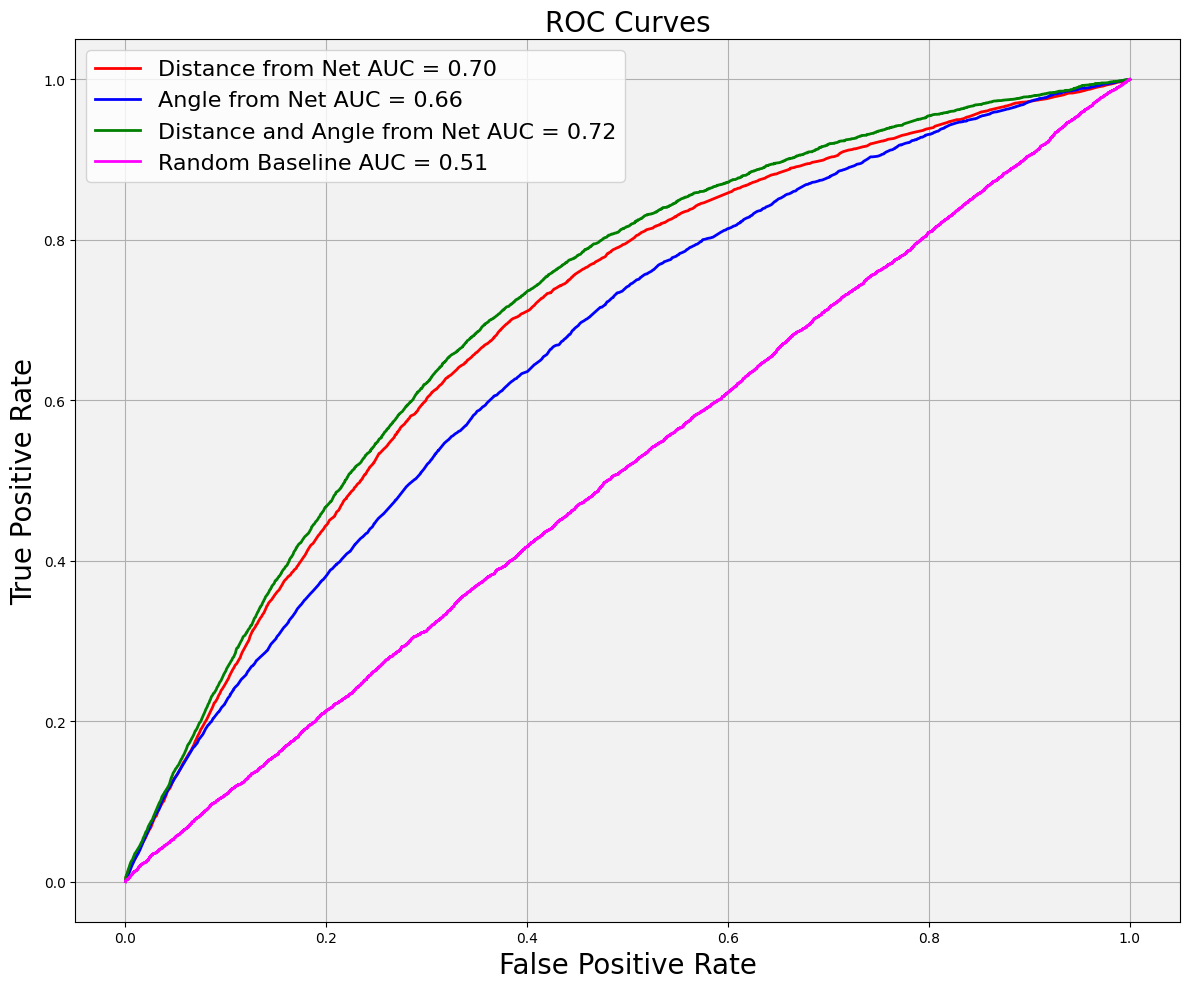

Accuracy score is 0.90552780705372
Accuracy score is 0.9054514350303197
Accuracy score is 0.9055889046724404


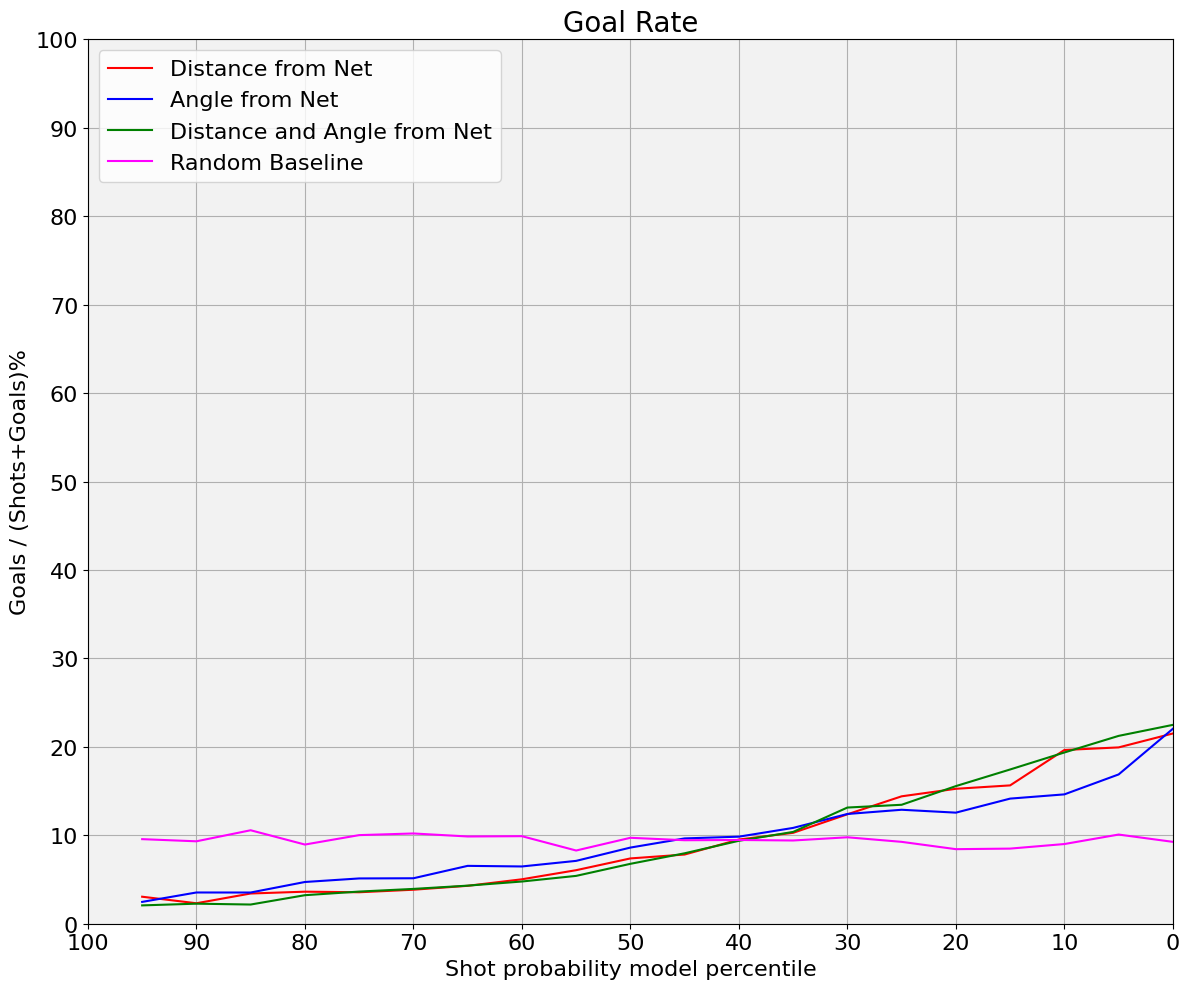

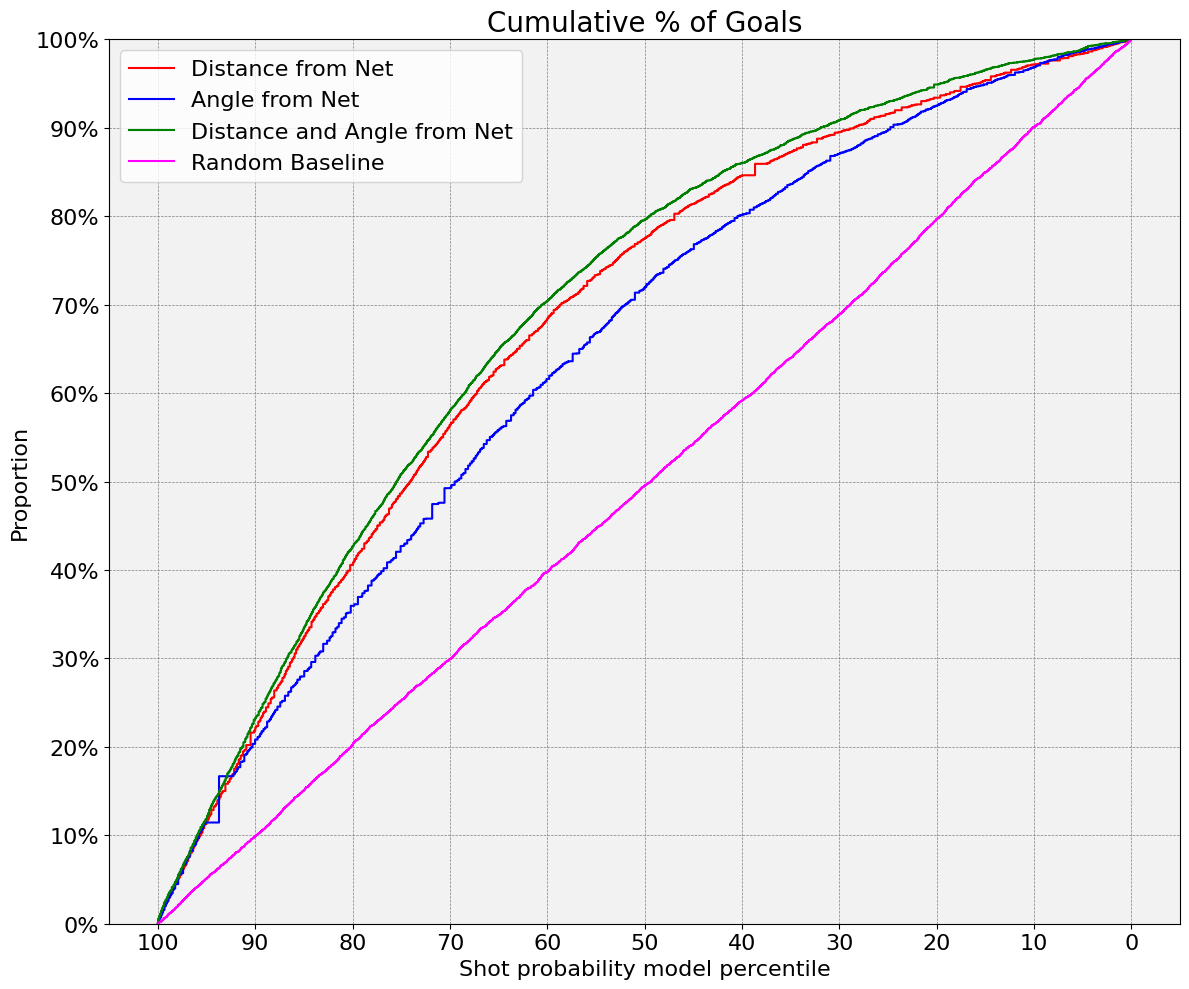

Accuracy score is 0.90552780705372
Accuracy score is 0.9054514350303197
Accuracy score is 0.9055889046724404


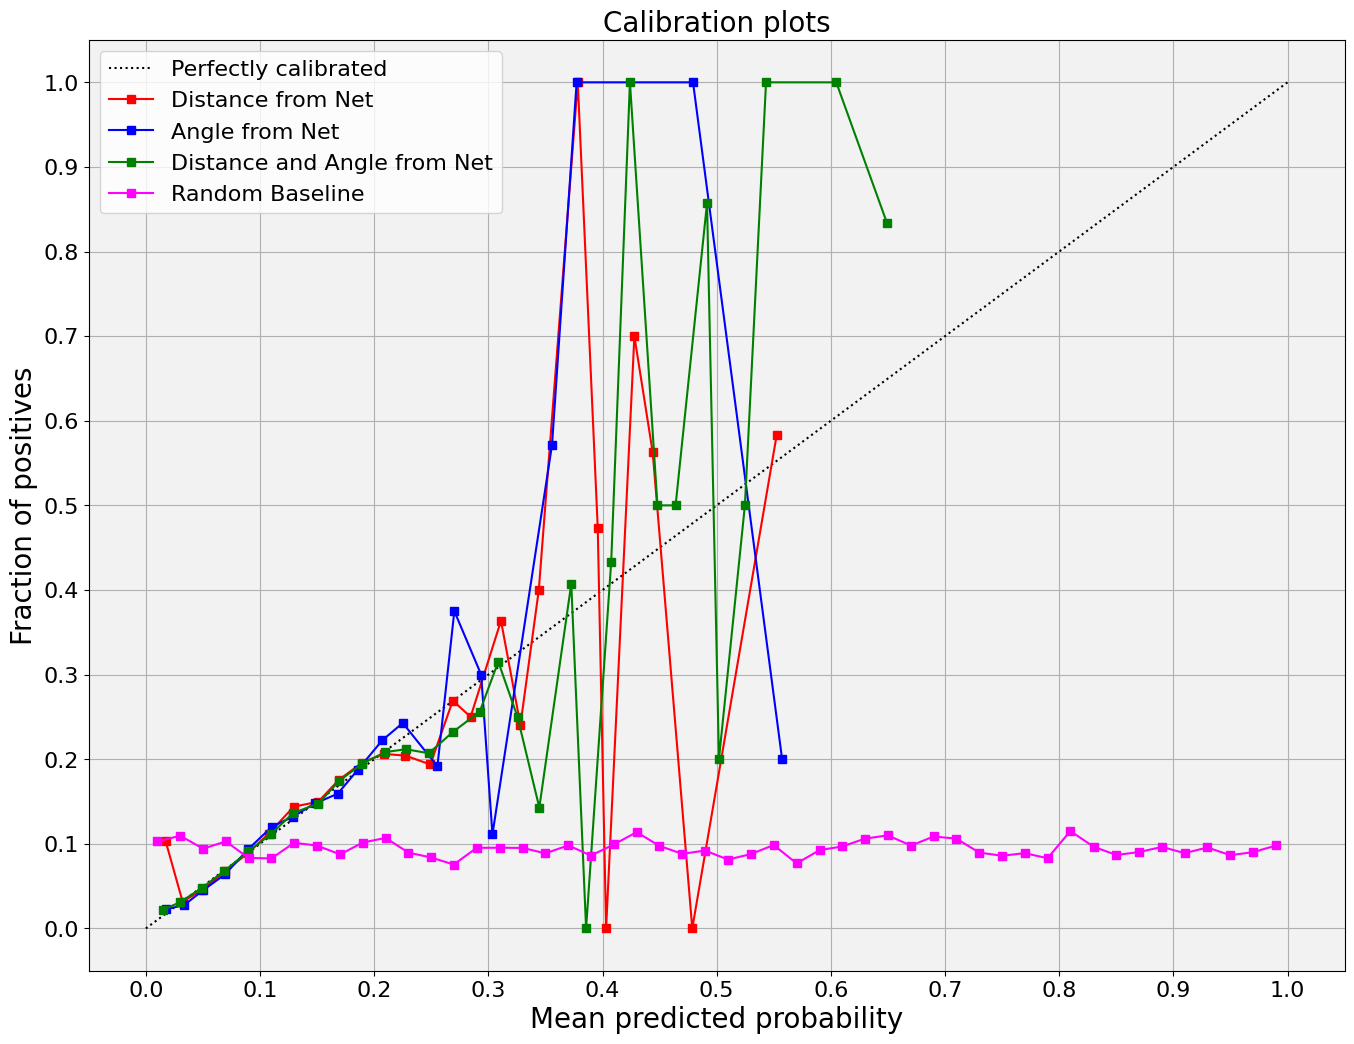

In [12]:
plot_roc_all_feat(X, y, model, '5-1a ROC Curves')
plot_goal_rate_all_feat(X, y, model, '5-1b Goal rate')
plot_cumulative_rate_all_feat(X, y, model, '5-1c Cumulative Goal Percentage')
plot_calibration_all_feat(X, y, model, '5-1d Calibration Plots')